In [263]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from scipy import signal

# Setting up the 1D data and template

In [300]:
nside = 32

map_ = np.zeros(12*nside**2)
map_[1000] = 1
map_[10000] = 0.6

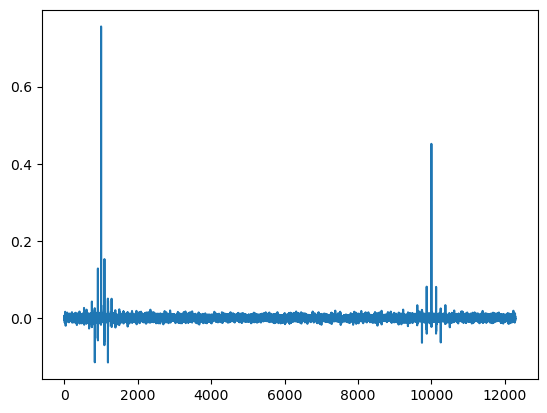

In [301]:
map_1d = hp.smoothing(map_) + 5e-3*np.random.randn(len(map_))
plt.plot(map_1d)

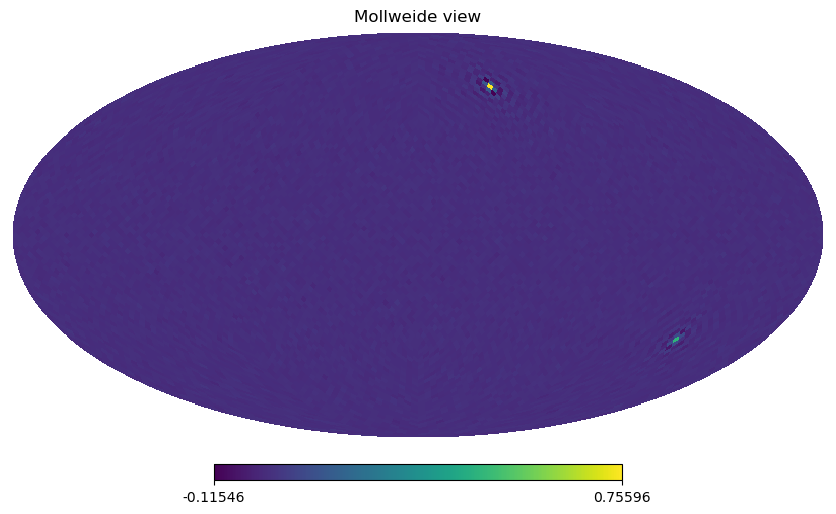

In [302]:
hp.mollview(map_1d)

In [303]:
template_ = np.zeros_like(map_1d)
template_[len(template_)//2] = 1
template_1d = hp.smoothing(template_)

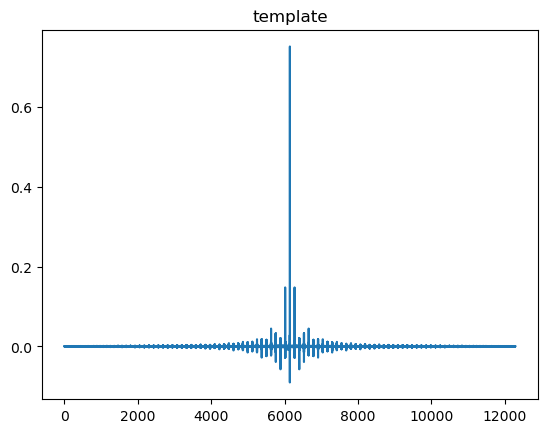

In [304]:
plt.plot(template_1d)
plt.title('template')
plt.show()

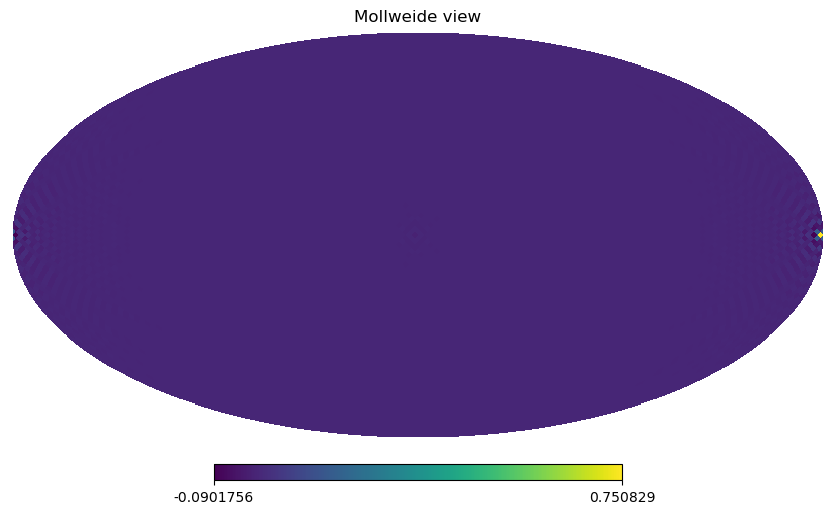

In [305]:
hp.mollview(template_1d)

# Looking at noise properties

In [306]:
def smooth_vector(vec, sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

In [307]:
Ninv_smoothing_sigma = 10
x = np.linspace(-np.pi/2,np.pi/2,len(map_1d))
win = signal.windows.tukey(len(x))
ps = np.abs(np.fft.fft(map_1d * win))**2
ps_smooth=smooth_vector(ps, Ninv_smoothing_sigma)
Ninv=1/ps_smooth

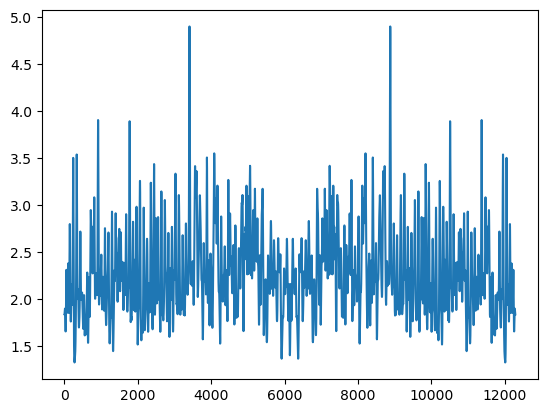

In [308]:
plt.plot(Ninv)

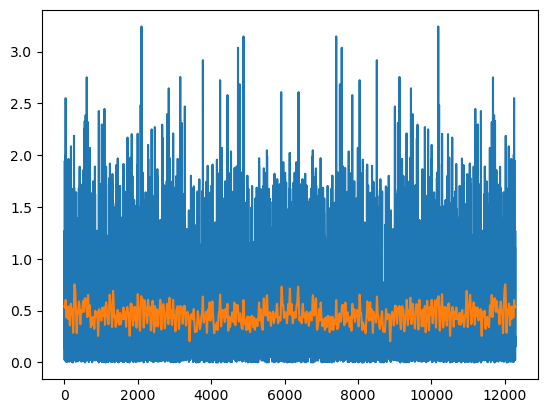

In [309]:
plt.plot(ps)
plt.plot(ps_smooth)

In [310]:
## Step 6: Preparing template for mf
template_ft = np.fft.fft(template_1d*win)
template_ft_white = template_ft * np.sqrt(Ninv)

## Step 6: Preparing data for mf
data_ft = np.fft.fft(map_1d*win)
data_ft_white = data_ft * np.sqrt(Ninv)

## Step 7: Computing matched filter
rhs = np.real(np.fft.ifft(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf = rhs / lhs

In [313]:
peaks, _ = signal.find_peaks(mf/np.max(mf), height=0.3)

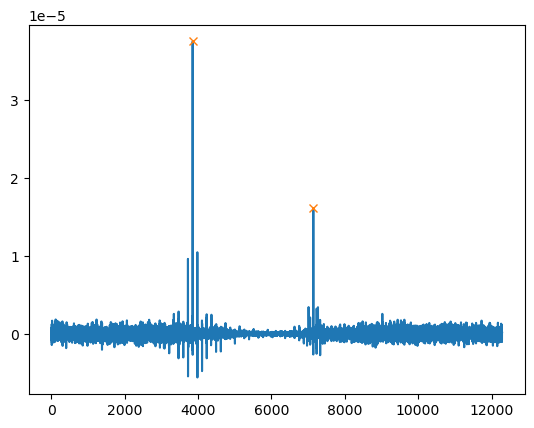

In [314]:
plt.plot(mf)
plt.plot(peaks, mf[peaks], "x")

In [315]:
peaks

array([3856, 7144])

In [316]:
peaks_data, _ = signal.find_peaks(map_1d/np.max(map_1d), height=0.5)
peaks_data

array([ 1000, 10000])

In [317]:
peaks_temp, _ = signal.find_peaks(template_1d/np.max(template_1d), height=0.5)
peaks_temp

array([6144])

In [318]:
6144 + 3856

10000

In [319]:
6144 + 7144

13288

In [321]:
map_1d.shape[0] - 13288

-1000

In [322]:
## need to make sure I have a proper way to say which pixel it is at

Checking intermediate products

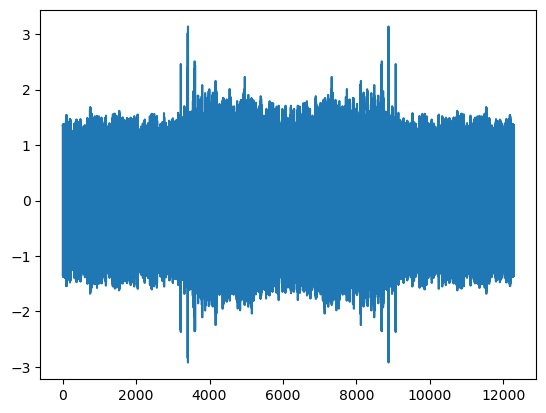

In [328]:
plt.plot(template_ft_white)

/opt/anaconda3/envs/CHORD/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/CHORD/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


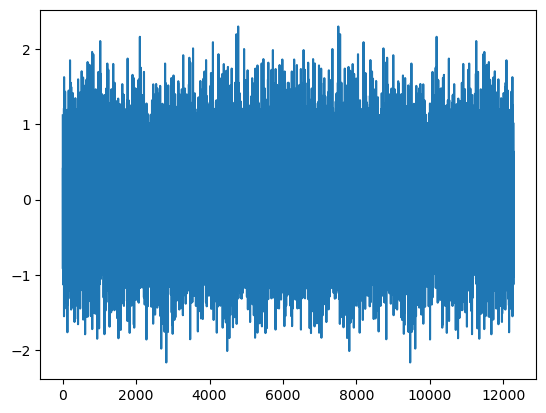

In [329]:
plt.plot(data_ft_white)

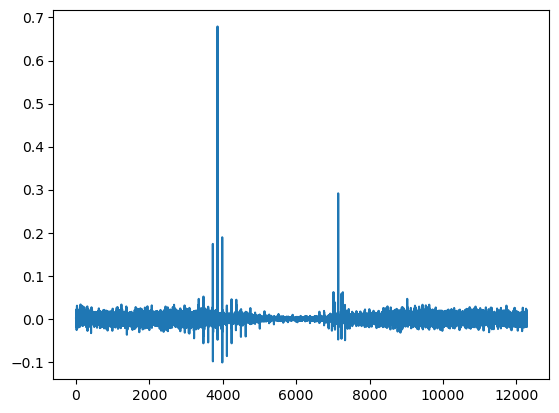

In [330]:
plt.plot(rhs)

In [332]:
lhs

18093.48549606662

# Coming up with 2D map and template

In [333]:
x_b = np.linspace(-15, 15, 100)

In [334]:
from scipy import special

airy = special.jv(1, x_b*2*np.pi)/x_b/2/np.pi
airy[len(airy)//2] = airy[len(airy)//2-1]

airy_2d = np.outer(airy, airy)

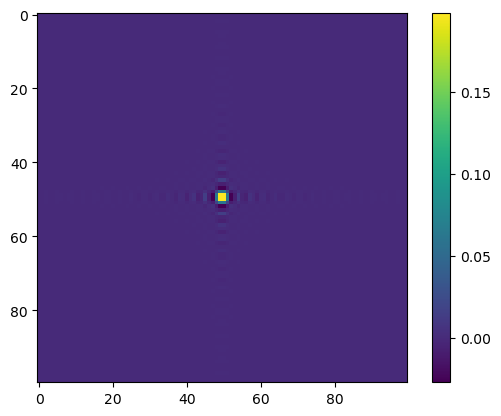

In [335]:
plt.imshow(airy_2d)
plt.colorbar()

In [336]:
map_2d = np.zeros((100,100))
map_2d[20,80] = 1
map_2d = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(map_2d)*np.fft.fft2(airy_2d))).real + 3e-3*np.random.randn(100,100)

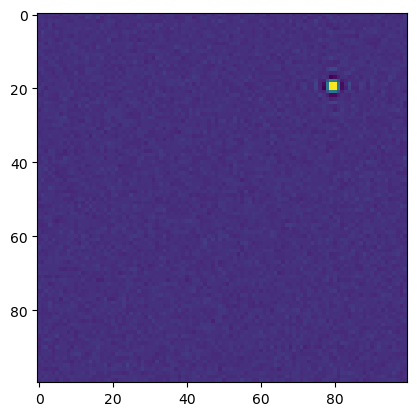

In [337]:
plt.imshow(map_2d)

# attempting 2D matched filter

In [338]:
win_temp = signal.windows.tukey(100)
win_2d = np.sqrt(np.outer(win_temp,win_temp))
ps_2d = np.abs(np.fft.fft2(map_2d * win_2d))**2
ps_smooth_2d = smooth_vector(ps_2d, Ninv_smoothing_sigma)
Ninv_2d = 1/ps_smooth_2d

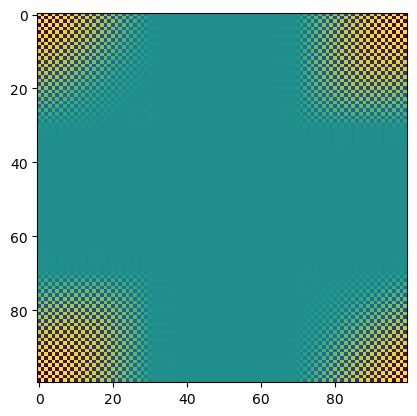

In [348]:
plt.imshow(np.fft.fft2(airy_2d).real)

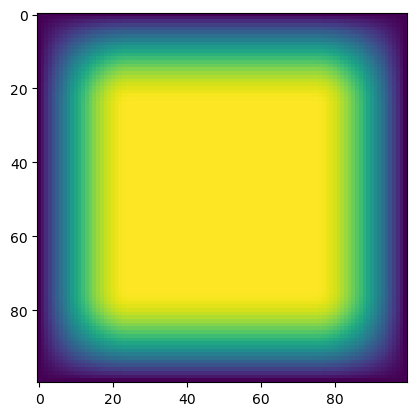

In [352]:
plt.imshow(win_2d)

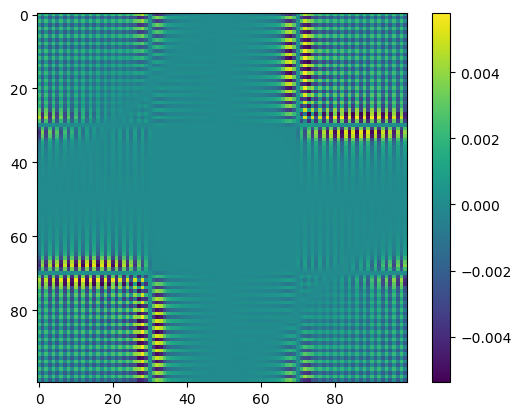

In [351]:
plt.imshow(np.fft.fft2(airy_2d*win_2d).real - np.fft.fft2(airy_2d).real)
plt.colorbar()

In [344]:
## Step 6: Preparing template for mf
template_ft = np.fft.fft2(airy_2d*win_2d)
template_ft_white = template_ft * np.sqrt(Ninv_2d)

## Step 6: Preparing data for mf
data_ft = np.fft.fft2(map_2d*win_2d)
data_ft_white = data_ft * np.sqrt(Ninv_2d)

## Step 7: Computing matched filter
rhs = np.real(np.fft.ifft2(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf_2d = rhs / lhs

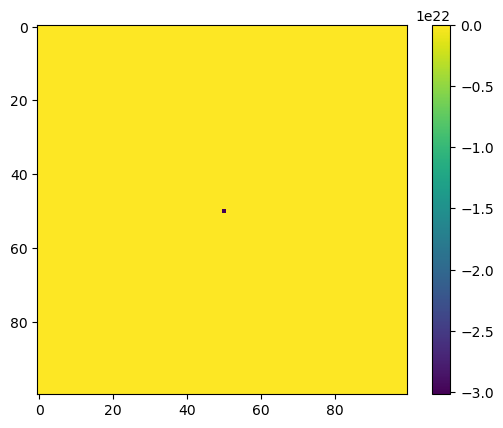

In [242]:
plt.imshow(mf_2d)
plt.colorbar()

In [243]:
idx = np.unravel_index(np.argmax(mf_2d), mf_2d.shape)
idx

(50, 51)

In [244]:
idx = np.unravel_index(np.argmax(map_2d), map_2d.shape)
idx

(20, 79)

In [245]:
idx = np.unravel_index(np.argmax(airy_2d), airy_2d.shape)
idx

(49, 49)

In [254]:
tetsing = np.fft.fftshift(np.fft.ifft2(data_ft_white*template_ft_white)).real
div = (template_ft_white.T @ template_ft_white).real

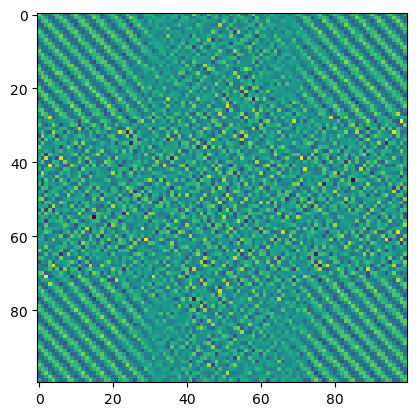

In [262]:
plt.imshow(data_ft_white.real)

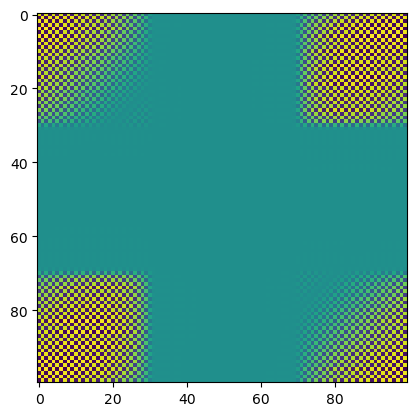

In [261]:
plt.imshow(template_ft_white.real)

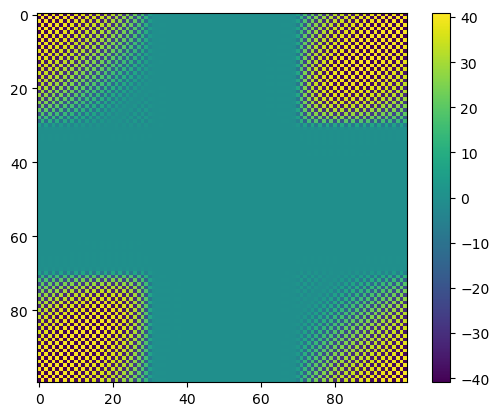

In [259]:
plt.imshow(div)
plt.colorbar()

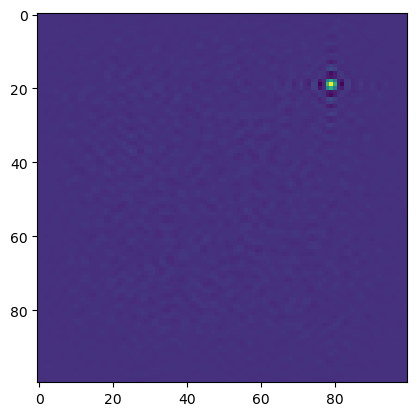

In [257]:
plt.imshow(tetsing)

# turning into 2D map for comparison

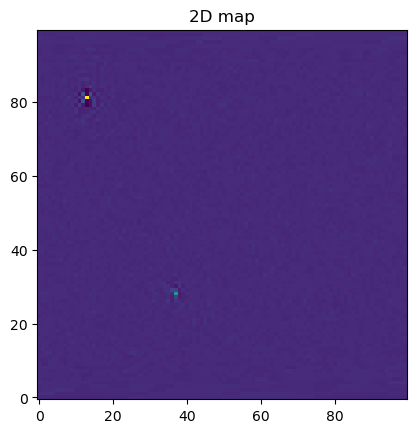

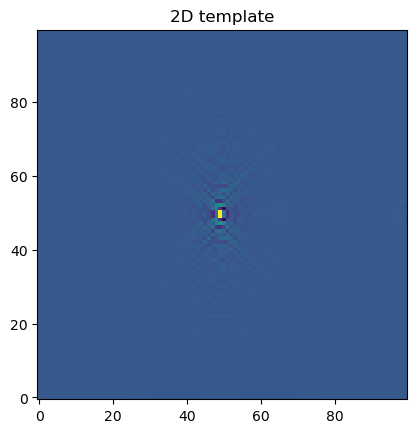

In [32]:
from functools import partial

n_pixels = 100

# Get the cutout via a cartesian projection
lonra = [0, 360]
latra = [-90, 90]

proj = hp.projector.CartesianProj(
    lonra=lonra, latra=latra,
    coord='G',
    xsize=n_pixels, ysize=n_pixels)

map_2d = proj.projmap(smooth_1d, vec2pix_func=partial(hp.vec2pix, 32))
template_2d = proj.projmap(smooth_template, vec2pix_func=partial(hp.vec2pix, 32))

# Plot the cutout
plt.imshow(map_2d, origin='lower', interpolation='nearest')
plt.title('2D map')
plt.show()

plt.imshow(template_2d, origin='lower', interpolation='nearest')
plt.title('2D template')
plt.show()


# 2D matched filter

In [57]:
win_temp = signal.windows.tukey(n_pixels)
win_2d = np.sqrt(np.outer(win_temp,win_temp))
ps_2d = np.abs(np.fft.fft2(map_2d * win_2d))**2
ps_smooth_2d = smooth_vector(ps_2d, Ninv_smoothing_sigma)
Ninv_2d = 1/ps_smooth_2d

In [58]:
## Step 6: Preparing template for mf
print('whitening template')
template_ft = np.fft.fft2(template_2d*win_2d)
template_ft_white = template_ft * np.sqrt(Ninv_2d)

## Step 6: Preparing data for mf
print('whitening data')
data_ft = np.fft.fft2(map_2d*win_2d)
data_ft_white = data_ft * np.sqrt(Ninv_2d)

## Step 7: Computing matched filter
print('computing mf')
rhs = np.real(np.fft.ifft2(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf_2d = rhs / lhs

whitening template
whitening data
computing mf


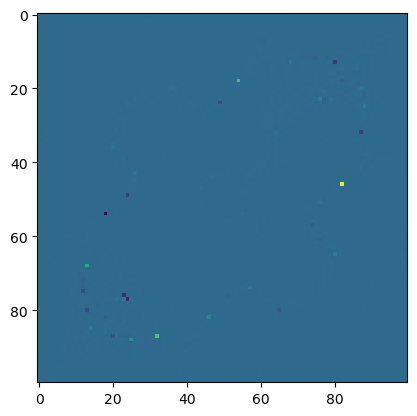

In [59]:
plt.imshow(mf_2d)
plt.show()

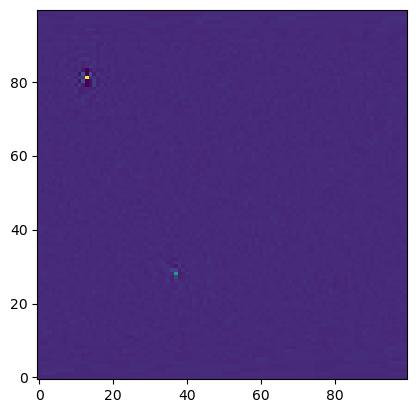

In [60]:
plt.imshow(map_2d, origin='lower', interpolation='nearest')